# PyDMD

## Tutorial 4: Decomposição do modo dinâmico compactado

Neste tutorial mostraremos a análise e a reconstrução de um sistema genérico utilizando a decomposição em modo dinâmico compactado (cDMD). Como referência, siga [este trabalho](https://doi.org/10.1007/s11554-016-0655-2) de Erichson, Brunton e Kutz. Nesta variação do algoritmo original, a matriz dos instantâneos é comprimida através de uma pré-multiplicação por uma matriz própria, e então a matriz comprimida é decomposta.

Primeiramente importamos as classes CDMD e DMD do pacote pydmd, configuramos matplotlib para o notebook, importamos numpy e o pacote time para alguns benchmarks futuros.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from pydmd import CDMD
from pydmd import DMD

# Paso Nº1: Creando los datos (2 Variables (x,t))

Agora, criamos uma função auxiliar que retorna os instantâneos de entrada de uma determinada resolução espacial e temporal.
Como nos tutoriais anteriores, o sistema estudado é obtido a partir da soma de diferentes funções:<br>
- $f_1(x, t) = e^{\frac{-x^2}{5}}\,\cos(4x)\,e^{(2.3i)t}$
- $f_2(x, t) = (1-e^{1-\frac{x^2}{6}})e^{(1.3i)t}$
- $f_3(x, t) = (-\frac{x^2}{50} + 1)1.1i^{-2t}$

In [2]:
def create_dataset(x_dim, t_dim):
    
    # Creamos una lista en x 
    x = np.linspace(-5, 5, x_dim)

    # Creamos una lista en t
    t = np.linspace(0, 4 * np.pi, t_dim)

    def f1(x, t):
        return np.exp(-(x**2) * 0.2) * np.cos(4 * x) * np.exp(2.3j * t)

    def f2(x, t):
        return (1 - np.exp(1 - x**2 / 6)) * np.exp(1.3j * t)

    def f3(x, t):
        return (-0.02 * x**2 + 1) * (1.1j ** (-2 * t))


    # Creamos una malla con 2 tipos de valores
    
    xgrid, tgrid = np.meshgrid(x, t)

    X1 = f1(xgrid, tgrid)
    X2 = f2(xgrid, tgrid)
    X3 = f3(xgrid, tgrid)
    
    print("\n")
    print(f"La matriz generada es del orden de {(X1 + X2 + X3).shape}")
    print("\n")
    print(f"La matriz generada tiene: {(X1 + X2 + X3).shape[1]} filas, las cuales indican el tamanho de X ")
    print("\n")
    print(f"La matriz generada tiene: {(X1 + X2 + X3).shape[0]} columnas, las cuales indican el tamanho de t ")
    print("\n")
    #xgrid, tgrid, 
    return  xgrid, tgrid, (X1 + X2 + X3)

O gráfico abaixo representa o conjunto de dados.



La matriz generada es del orden de (128, 256)


La matriz generada tiene: 256 filas, las cuales indican el tamanho de X 


La matriz generada tiene: 128 columnas, las cuales indican el tamanho de t 




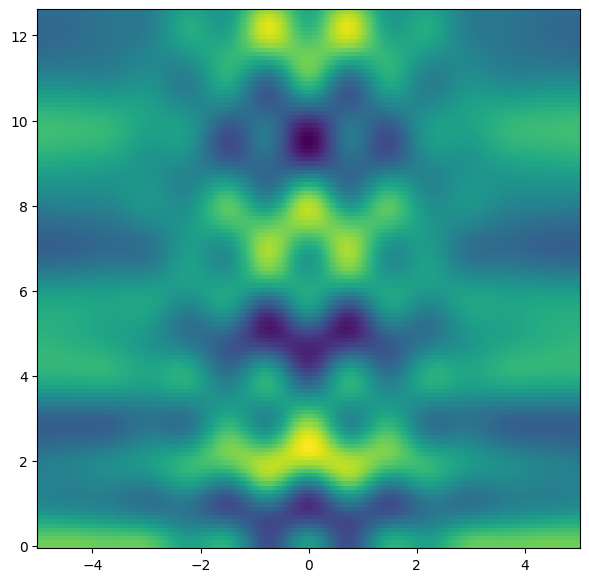

In [3]:
# return xgrid, tgrid, (X1 + X2 + X3)
# Aplicamos a nuestros dados 
# def create_dataset(x_dim, t_dim):
xgrid, tgrid,X = create_dataset(256, 128)

# Se grafica el sistema 
plt.figure(figsize=(7, 7))
plt.pcolor(xgrid, tgrid, X.real)
plt.show()

Para compactar o conjunto de dados, precisamos construir a matriz que pré-multiplica a matriz de instantâneos. A classe `CDMD` fornece os seguintes arrays (Vectores) pré-construídos:
- *normal*: uma matriz com dimensão (`nsnaps`, `ndim`) onde os elementos são gerados aleatoriamente com distribuição normal com média igual a 0,0 e desvio padrão igual a 1,0;
- *uniforme*: uma matriz com dimensão (`nsnaps`, `ndim`) onde os elementos são gerados aleatoriamente com distribuição uniforme entre 0 e 1;
- *sparse*: uma matriz aleatória esparsa com dimensão (`nsnaps`, `ndim`);
- *amostra*: uma matriz com dimensão (`nsnaps`, `ndim`) onde cada linha contém um elemento igual a 1 e todos os outros elementos são nulos.

Basta passar a string correta no momento da criação do novo objeto para escolher a matriz. Caso contrário é possível utilizar uma matriz customizada para a compressão, como mostramos a seguir.

In [4]:
# Siempre es la matriz transpuesta de los datos inciales 
snapshots_matrix = X.T

# total de elementos en la matriz como un array (vector de tamanho 0 x (mxn) ) 
random_matrix = np.random.permutation(
    snapshots_matrix.shape[0] * snapshots_matrix.shape[1]
)

# cambia los elementos del array "random matrix" al tamnho de la matriz "snapshots_matrix" que es de (128, 256)
random_matrix = random_matrix.reshape(
    snapshots_matrix.shape[1], snapshots_matrix.shape[0]
)

# Dividimos cada elemento de la matriz por la norma a modo  escalar los datos para que tengan una magnitud comparable.
compression_matrix = random_matrix / np.linalg.norm(random_matrix)

Creamos una instancia de la matriz `cDMD`, pasando como argumento `compression_matrix` la matriz que creamos. El constructor es muy similar a la clase `DMD`, excepto por la matriz de compresión y la falta del argumento `exacto` (en la versión comprimida, sólo hay una forma de calcular los modos). Trazamos los modos y la dinámica.

C:\Users\Meu Computador\AppData\Roaming\Python\Python312\site-packages\pydmd\snapshots.py:73: UserWarning: Input data condition number 8.026400196790509e+17. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


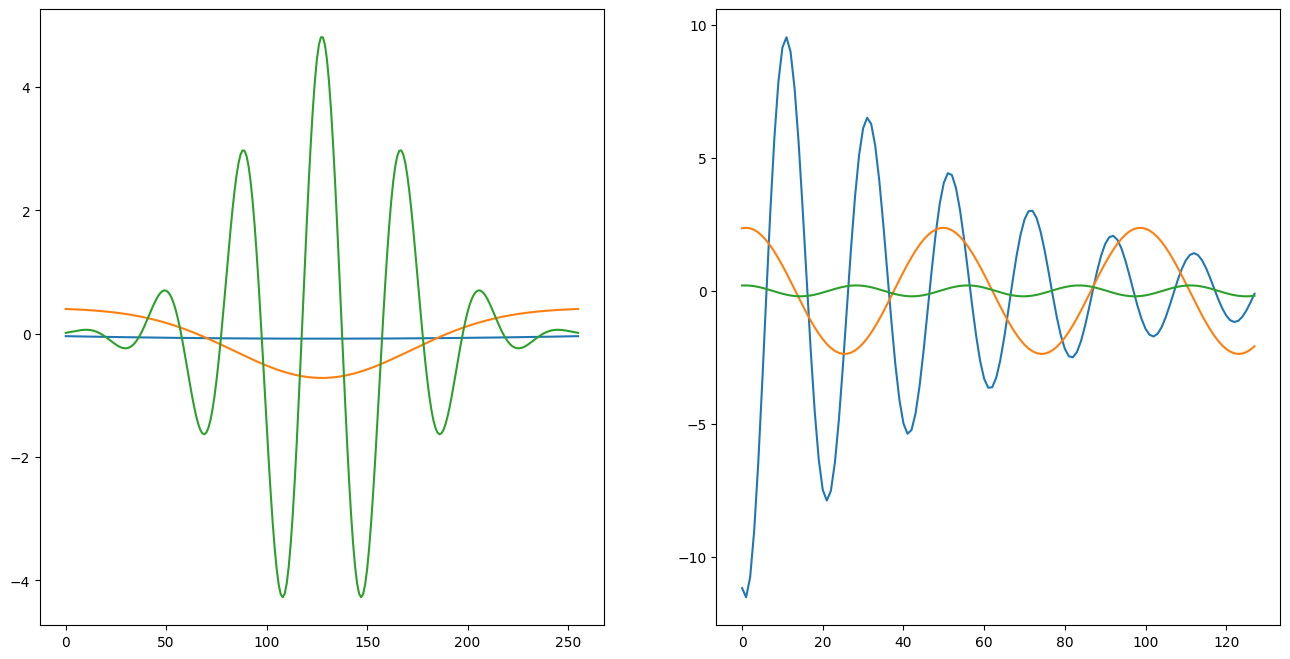

In [5]:
# Abres la instancia multiplicando por esa matriz 
# classCDMD(svd_rank=0, tlsq_rank=0, compression_matrix='uniform', opt=False, rescale_mode=None, forward_backward=False, sorted_eigs=False, tikhonov_regularization=None)
cdmd = CDMD(svd_rank=3, compression_matrix=compression_matrix)

# Llamas a la matriz de tus datos 
cdmd.fit(snapshots_matrix)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(cdmd.modes.real)
plt.subplot(1, 2, 2)
plt.plot(cdmd.dynamics.T.real)
plt.show()

Para investigar la precisión de la reconstrucción, comparamos los resultados obtenidos con el cDMD y el DMD estándar, respectivamente.

DMD error: 7.259701926983806e-12
CDMD error: 7.65580682563969e-12


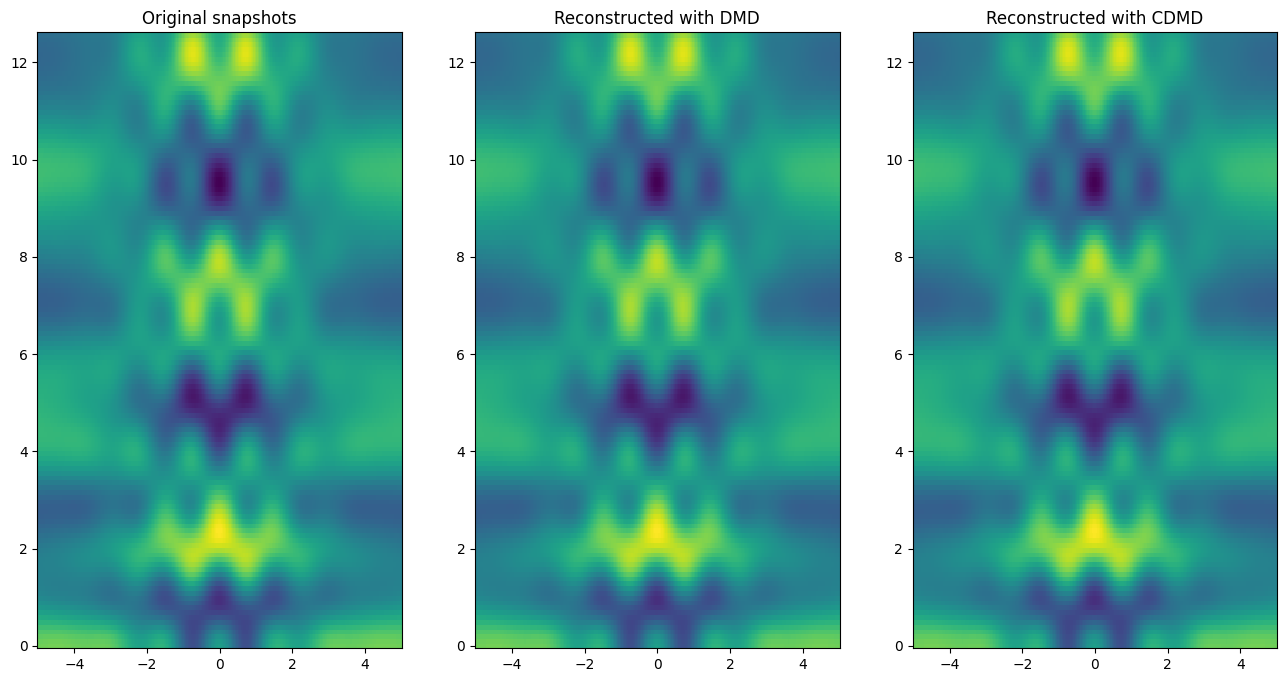

In [6]:
# Crear la instancia para la aplicacion del DMD

dmd = DMD(svd_rank=3, exact=True)

# Aplicamos esa instancioa a nuestros datos 
dmd.fit(snapshots_matrix)

# Se calcula el determinantes de: (matrix original - reconstruccion_DMD)
dmd_error = np.linalg.norm(snapshots_matrix - dmd.reconstructed_data)

# Se calcula el determinantes de: (matrix original - reconstruccion_CDMD)
cdmd_error = np.linalg.norm(snapshots_matrix - cdmd.reconstructed_data)
print("DMD error: {}".format(dmd_error))
print("CDMD error: {}".format(cdmd_error))

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.title("Original snapshots")
plt.pcolor(xgrid, tgrid, snapshots_matrix.real.T)
plt.subplot(1, 3, 2)
plt.title("Reconstructed with DMD")
plt.pcolor(xgrid, tgrid, dmd.reconstructed_data.real.T)
plt.subplot(1, 3, 3)
plt.title("Reconstructed with CDMD")
plt.pcolor(xgrid, tgrid, cdmd.reconstructed_data.real.T)
plt.show()

El error al usar la entrada comprimida es ligeramente mayor, pero la reconstrucción se ve muy similar a la entrada original. Entonces, ¿por qué necesitamos el algoritmo comprimido en lugar del original? La matriz de instantáneas sin compresión tiene la dimensión *ndim $\times$ nsnapshots*, donde *ndim* es la dimensión de cada instantánea y *nsnapshots* es el número de instantáneas. La matriz de instantáneas comprimidas es, en cambio, una matriz *nsnapshots $\times$ nsnapshots*; así, además de una útil reducción de ruido debido a la compresión, esta versión permite un cálculo más rápido. Midámoslo.



La matriz generada es del orden de (100, 100)


La matriz generada tiene: 100 filas, las cuales indican el tamanho de X 


La matriz generada tiene: 100 columnas, las cuales indican el tamanho de t 




La matriz generada es del orden de (100, 1000)


La matriz generada tiene: 1000 filas, las cuales indican el tamanho de X 


La matriz generada tiene: 100 columnas, las cuales indican el tamanho de t 




C:\Users\Meu Computador\AppData\Roaming\Python\Python312\site-packages\pydmd\snapshots.py:73: UserWarning: Input data condition number 7.273120175960295e+33. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\Meu Computador\AppData\Roaming\Python\Python312\site-packages\pydmd\snapshots.py:73: UserWarning: Input data condition number 1.7898767812737507e+17. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(




La matriz generada es del orden de (100, 10000)


La matriz generada tiene: 10000 filas, las cuales indican el tamanho de X 


La matriz generada tiene: 100 columnas, las cuales indican el tamanho de t 




C:\Users\Meu Computador\AppData\Roaming\Python\Python312\site-packages\pydmd\snapshots.py:73: UserWarning: Input data condition number 1.1643682296987186e+17. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(




La matriz generada es del orden de (100, 100000)


La matriz generada tiene: 100000 filas, las cuales indican el tamanho de X 


La matriz generada tiene: 100 columnas, las cuales indican el tamanho de t 




C:\Users\Meu Computador\AppData\Roaming\Python\Python312\site-packages\pydmd\snapshots.py:73: UserWarning: Input data condition number 1.0904897672548347e+17. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


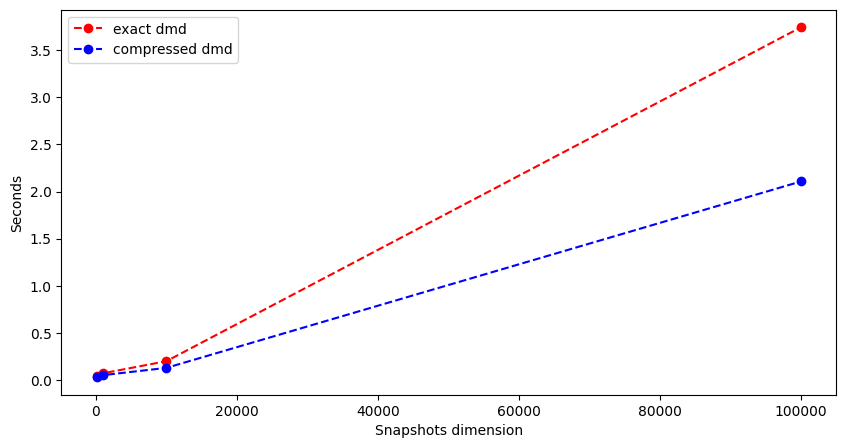

In [7]:
time_dmd = []
time_cdmd = []
dim = []

niter = 4

# Vector de dimension (2-(2+niter))=4 
ndims = 10 ** np.arange(2, 2 + niter)

nsnaps = [100] * niter

for nsnap, ndim in zip(nsnaps, ndims):
    snapshots_matrix = create_dataset(ndim, nsnap)[-1].T
    dim.append(snapshots_matrix.shape[0])
    random_matrix = np.random.permutation(
        snapshots_matrix.shape[0] * snapshots_matrix.shape[1]
    )
    random_matrix = random_matrix.reshape(
        snapshots_matrix.shape[1], snapshots_matrix.shape[0]
    )

    compression_matrix = random_matrix / np.linalg.norm(random_matrix)

    t0 = time.time()
    DMD(svd_rank=-1, exact=True).fit(snapshots_matrix)
    t1 = time.time()
    time_dmd.append(t1 - t0)

    t0 = time.time()
    CDMD(svd_rank=-1, compression_matrix=compression_matrix).fit(
        snapshots_matrix
    )
    t1 = time.time()
    time_cdmd.append(t1 - t0)

plt.figure(figsize=(10, 5))
plt.plot(dim, time_dmd, "ro--", label="exact dmd")
plt.plot(dim, time_cdmd, "bo--", label="compressed dmd")
plt.legend()
plt.ylabel("Seconds")
plt.xlabel("Snapshots dimension")
plt.show()

A compressão de entrada, neste caso, reduz pela metade o tempo computacional, com apenas uma perda de qualidade insignificante. Experimente esta técnica com seus maiores conjuntos de dados e compartilhe conosco seus resultados!